# Model Retraining

## Preliminaries

In [1]:
# general
import os
from tqdm import tqdm

# wandb - hyperparameter sweep and Train monitoring
import wandb
#torch - computing and machine learning libraries
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
# seisbench
import seisbench.models as sbm

#plotting
import matplotlib.pyplot as plt
# seisynth
from utils.common import load_dataset_and_labels, load_pretrained_model

In [2]:
# Possible values
DATASETS_ORIGINS = ['ethz', 'geofon']
SBM_CLASSES= [sbm.PhaseNet, sbm.EQTransformer]
MODEL_TO_NUM_SAMPLES = {sbm.EQTransformer:6000, sbm.PhaseNet: 3001}

In [3]:
dataset_origin = 'geofon'
assert dataset_origin in DATASETS_ORIGINS, f'Expected dataset one of {DATASETS_ORIGINS}. Got {dataset_origin}.'

In [4]:
SBM_CLASS= sbm.PhaseNet
assert SBM_CLASS in SBM_CLASSES
SBM_CLASS

seisbench.models.phasenet.PhaseNet

In [5]:
NUM_SAMPLES=MODEL_TO_NUM_SAMPLES[SBM_CLASS]
NUM_SAMPLES

3001

In [6]:
NUM_SHIFTS=6
SAMPLE_RATE=100
LARGE_ERROR_THRESHOLD_SECONDS=1
LARGE_ERROR_THRESHOLD_SAMPLES=LARGE_ERROR_THRESHOLD_SECONDS*SAMPLE_RATE

In [7]:
SYNTHESIZED_SNR_LIST= list(range(2,11))
SYNTHESIZED_SNR_LIST

[2, 3, 4, 5, 6, 7, 8, 9, 10]

In [8]:
def assert_path_exists(path_str: str, name: str=''):
    assert os.path.exists(path_str), f'{name} {path_str} does not exist'

@torch.no_grad()
def standardize(trace: torch.tensor):
    m = trace.mean(dim=-1, keepdim=True).unsqueeze(dim=0)
    std = trace.std(dim=-1, keepdim=True).unsqueeze(dim=0)
    trace = trace.unsqueeze(dim=0) if trace.dim() == 1 else trace
    standardized = torch.stack([(trace[ch] - m[0, ch]) / std[0, ch] for ch in range(trace.shape[0])], dim=0)
    assert standardized.shape == trace.shape, f'Standardization should not change shape. Got {standardized.shape}'
    return standardized

In [9]:
DATASET_PATH=f'/home/moshe/datasets/GFZ/noisy_datasets/{dataset_origin}_trainset_{NUM_SAMPLES}_sample_joachim_noises_energy_ratio_snr/'
assert_path_exists(path_str=DATASET_PATH, name='DATASET_PATH')
DATASET_PATH

'/home/moshe/datasets/GFZ/noisy_datasets/geofon_trainset_3001_sample_joachim_noises_energy_ratio_snr/'

In [10]:
NOISY_DATA_PATH_LIST = [os.path.join(DATASET_PATH, f'noisy_small_dataset_snr_{synthesized_snr}') for synthesized_snr in SYNTHESIZED_SNR_LIST]
for p in NOISY_DATA_PATH_LIST:
    assert_path_exists(path_str=p)
NOISY_DATA_PATH_LIST

['/home/moshe/datasets/GFZ/noisy_datasets/geofon_trainset_3001_sample_joachim_noises_energy_ratio_snr/noisy_small_dataset_snr_2',
 '/home/moshe/datasets/GFZ/noisy_datasets/geofon_trainset_3001_sample_joachim_noises_energy_ratio_snr/noisy_small_dataset_snr_3',
 '/home/moshe/datasets/GFZ/noisy_datasets/geofon_trainset_3001_sample_joachim_noises_energy_ratio_snr/noisy_small_dataset_snr_4',
 '/home/moshe/datasets/GFZ/noisy_datasets/geofon_trainset_3001_sample_joachim_noises_energy_ratio_snr/noisy_small_dataset_snr_5',
 '/home/moshe/datasets/GFZ/noisy_datasets/geofon_trainset_3001_sample_joachim_noises_energy_ratio_snr/noisy_small_dataset_snr_6',
 '/home/moshe/datasets/GFZ/noisy_datasets/geofon_trainset_3001_sample_joachim_noises_energy_ratio_snr/noisy_small_dataset_snr_7',
 '/home/moshe/datasets/GFZ/noisy_datasets/geofon_trainset_3001_sample_joachim_noises_energy_ratio_snr/noisy_small_dataset_snr_8',
 '/home/moshe/datasets/GFZ/noisy_datasets/geofon_trainset_3001_sample_joachim_noises_energ

## Load Pretrained Model

Load the model with the pretrained weights

In [11]:
pretrained_model = load_pretrained_model(model_class=SBM_CLASS, dataset_trained_on=dataset_origin)

Working with <class 'seisbench.models.phasenet.PhaseNet'> on GEOFON
Load <class 'seisbench.models.phasenet.PhaseNet'> pretrained weights
<class 'seisbench.models.phasenet.PhaseNet'> pretrained keys ['ethz', 'geofon', 'instance', 'iquique', 'lendb', 'neic', 'original', 'scedc', 'stead']


Save a copy for retraining. One model will be trained and the other one will keep the current weights for benchmarking on specific examples

In [12]:
# reloading because I cannot torch clone. Seisbench models are not nn.Module :(
# retraining_model = load_pretrained_model(model_class=SBM_CLASS, dataset_trained_on=dataset_origin)
retraining_model = sbm.PhaseNet(phases="PSN")

In [13]:
pretrained_model.eval()
# retraining_model.train()

PhaseNet(
  (inc): Conv1d(3, 8, kernel_size=(7,), stride=(1,), padding=same)
  (in_bn): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (down_branch): ModuleList(
    (0): ModuleList(
      (0): Conv1d(8, 8, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(8, 8, kernel_size=(7,), stride=(4,), padding=(3,), bias=False)
      (3): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ModuleList(
      (0): Conv1d(8, 16, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(16, 16, kernel_size=(7,), stride=(4,), bias=False)
      (3): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ModuleList(
      (0): Conv1d(16, 32, kernel_size=(7,), stride=(1,

## Load Datasets


We have 4 datasets:
1. original_dataset - ETHZ/GEOFON original traces filtered to have high estimated SNR - more than 20dB
2. le_original_dataset - A subset of the original_dataset (high SNR traces) that the pretrained model had a large picking error.
3. noised_dataset - Traces taken from the original dataset and merged with noise traces such that the resulting trace is a 10 dB SNR trace.
4. le_noised_dataset -  A subset of the noised_dataset that the pretrained model had a large picking error.

## Load Noisy Traces

Load synthetic noisy traces with various SNR levels and mix them.

In [14]:
NOISY_DATA_PATH_TRACES_LIST = [os.path.join(ndpl, 'traces.pt') for ndpl in NOISY_DATA_PATH_LIST]
for p in NOISY_DATA_PATH_TRACES_LIST:
    assert_path_exists(path_str=p)
NOISY_DATA_PATH_TRACES_LIST

['/home/moshe/datasets/GFZ/noisy_datasets/geofon_trainset_3001_sample_joachim_noises_energy_ratio_snr/noisy_small_dataset_snr_2/traces.pt',
 '/home/moshe/datasets/GFZ/noisy_datasets/geofon_trainset_3001_sample_joachim_noises_energy_ratio_snr/noisy_small_dataset_snr_3/traces.pt',
 '/home/moshe/datasets/GFZ/noisy_datasets/geofon_trainset_3001_sample_joachim_noises_energy_ratio_snr/noisy_small_dataset_snr_4/traces.pt',
 '/home/moshe/datasets/GFZ/noisy_datasets/geofon_trainset_3001_sample_joachim_noises_energy_ratio_snr/noisy_small_dataset_snr_5/traces.pt',
 '/home/moshe/datasets/GFZ/noisy_datasets/geofon_trainset_3001_sample_joachim_noises_energy_ratio_snr/noisy_small_dataset_snr_6/traces.pt',
 '/home/moshe/datasets/GFZ/noisy_datasets/geofon_trainset_3001_sample_joachim_noises_energy_ratio_snr/noisy_small_dataset_snr_7/traces.pt',
 '/home/moshe/datasets/GFZ/noisy_datasets/geofon_trainset_3001_sample_joachim_noises_energy_ratio_snr/noisy_small_dataset_snr_8/traces.pt',
 '/home/moshe/datase

In [15]:
NOISY_DATA_PATH_LABELS_LIST = [os.path.join(ndpl, 'labels.pt') for ndpl in NOISY_DATA_PATH_LIST]
for p in NOISY_DATA_PATH_LABELS_LIST:
    assert_path_exists(path_str=p)
NOISY_DATA_PATH_LABELS_LIST

['/home/moshe/datasets/GFZ/noisy_datasets/geofon_trainset_3001_sample_joachim_noises_energy_ratio_snr/noisy_small_dataset_snr_2/labels.pt',
 '/home/moshe/datasets/GFZ/noisy_datasets/geofon_trainset_3001_sample_joachim_noises_energy_ratio_snr/noisy_small_dataset_snr_3/labels.pt',
 '/home/moshe/datasets/GFZ/noisy_datasets/geofon_trainset_3001_sample_joachim_noises_energy_ratio_snr/noisy_small_dataset_snr_4/labels.pt',
 '/home/moshe/datasets/GFZ/noisy_datasets/geofon_trainset_3001_sample_joachim_noises_energy_ratio_snr/noisy_small_dataset_snr_5/labels.pt',
 '/home/moshe/datasets/GFZ/noisy_datasets/geofon_trainset_3001_sample_joachim_noises_energy_ratio_snr/noisy_small_dataset_snr_6/labels.pt',
 '/home/moshe/datasets/GFZ/noisy_datasets/geofon_trainset_3001_sample_joachim_noises_energy_ratio_snr/noisy_small_dataset_snr_7/labels.pt',
 '/home/moshe/datasets/GFZ/noisy_datasets/geofon_trainset_3001_sample_joachim_noises_energy_ratio_snr/noisy_small_dataset_snr_8/labels.pt',
 '/home/moshe/datase

In [16]:
# noised_dataset_path= os.path.join(NOISY_DATA_PATH, 'traces.pt')
# assert_path_exists(path_str=noised_dataset_path)
# noised_labels_path= os.path.join(NOISY_DATA_PATH, 'labels.pt')
# assert_path_exists(path_str=noised_labels_path)
# noised_dataset_path, noised_labels_path

In [17]:
def load_dataset_from_tensors(traces_path_list: list[torch.tensor], labels_path_list: list[torch.tensor], indices_to_use: list[int]=[]):
    traces_list, labels_list = [], []
    for tp, lp in zip(traces_path_list, labels_path_list):
        traces,labels = load_dataset_and_labels(dataset_path=tp, labels_path=lp)
        if indices_to_use:
            traces, labels = traces[indices_to_use], labels[indices_to_use]
        traces_list.append(traces)
        labels_list.append(labels.unsqueeze(dim=1))
        print(f'traces_list {len(traces_list)} labels_list {len(labels_list)}')


    traces = torch.vstack(traces_list)
    labels = torch.vstack(labels_list).squeeze()
    print(f'traces shape {traces.shape} labels_list {labels.shape}')
    return traces, labels

noised_dataset, noised_labels = load_dataset_from_tensors(traces_path_list=NOISY_DATA_PATH_TRACES_LIST, labels_path_list=NOISY_DATA_PATH_LABELS_LIST, indices_to_use=list(range(1000)))

noised_dataset_size = noised_dataset.shape[0]

# noised_dataset, noised_labels = load_dataset_and_labels(dataset_path=noised_dataset_path, labels_path=noised_labels_path)

traces_list 1 labels_list 1
traces_list 2 labels_list 2
traces_list 3 labels_list 3
traces_list 4 labels_list 4
traces_list 5 labels_list 5
traces_list 6 labels_list 6
traces_list 7 labels_list 7
traces_list 8 labels_list 8
traces_list 9 labels_list 9
traces shape torch.Size([9000, 3, 3001]) labels_list torch.Size([9000])


In [18]:
print(f'Loaded {noised_dataset_size} traces')

Loaded 9000 traces


## Load Original Data - Various SNR Levels

The following are traces from the original dataset with SNR of all levels

In [19]:
# List of SNR bin edges to which the traces seperated
bounds = [-20, 0, 2, 5, 10, 20, 100]
# j=5
t_list, l_list = [], []
for j in range(len(bounds)-1):
    suffix = f'_{dataset_origin}_bounds_{bounds[j]}_{bounds[j+1]}.pt'
    t = os.path.join(DATASET_PATH, 'traces' + suffix)
    assert_path_exists(path_str=t)
    t_list.append(t)
    l = os.path.join(DATASET_PATH, 'labels' + suffix)
    assert_path_exists(path_str=l)
    l_list.append(l)
t_list, l_list

(['/home/moshe/datasets/GFZ/noisy_datasets/geofon_trainset_3001_sample_joachim_noises_energy_ratio_snr/traces_geofon_bounds_-20_0.pt',
  '/home/moshe/datasets/GFZ/noisy_datasets/geofon_trainset_3001_sample_joachim_noises_energy_ratio_snr/traces_geofon_bounds_0_2.pt',
  '/home/moshe/datasets/GFZ/noisy_datasets/geofon_trainset_3001_sample_joachim_noises_energy_ratio_snr/traces_geofon_bounds_2_5.pt',
  '/home/moshe/datasets/GFZ/noisy_datasets/geofon_trainset_3001_sample_joachim_noises_energy_ratio_snr/traces_geofon_bounds_5_10.pt',
  '/home/moshe/datasets/GFZ/noisy_datasets/geofon_trainset_3001_sample_joachim_noises_energy_ratio_snr/traces_geofon_bounds_10_20.pt',
  '/home/moshe/datasets/GFZ/noisy_datasets/geofon_trainset_3001_sample_joachim_noises_energy_ratio_snr/traces_geofon_bounds_20_100.pt'],
 ['/home/moshe/datasets/GFZ/noisy_datasets/geofon_trainset_3001_sample_joachim_noises_energy_ratio_snr/labels_geofon_bounds_-20_0.pt',
  '/home/moshe/datasets/GFZ/noisy_datasets/geofon_trainset

In [20]:
original_snr_binned_dataset, original_snr_binned_labels = load_dataset_from_tensors(traces_path_list=t_list, labels_path_list=l_list, indices_to_use=list(range(200)))

traces_list 1 labels_list 1
traces_list 2 labels_list 2
traces_list 3 labels_list 3
traces_list 4 labels_list 4
traces_list 5 labels_list 5
traces_list 6 labels_list 6
traces shape torch.Size([1200, 3, 3001]) labels_list torch.Size([1200])


In [21]:
print(f'Loaded {original_snr_binned_dataset.shape[0]} traces')

Loaded 1200 traces


Make the real data set size equal to the synthetic one and leave the rest for test

In [22]:
# original_snr_binned_dataset, original_snr_binned_labels, original_snr_binned_dataset_left_for_test, original_snr_binned_labels_left_for_test = original_snr_binned_dataset[:noised_dataset_size], original_snr_binned_labels[:noised_dataset_size], original_snr_binned_dataset[noised_dataset_size:], original_snr_binned_labels[noised_dataset_size:]

original_snr_binned_dataset, original_snr_binned_labels, original_snr_binned_dataset_left_for_test, original_snr_binned_labels_left_for_test = original_snr_binned_dataset[:100], original_snr_binned_labels[:100], original_snr_binned_dataset[100:], original_snr_binned_labels[100:]


original_snr_binned_dataset.shape, original_snr_binned_labels.shape, original_snr_binned_dataset_left_for_test.shape, original_snr_binned_labels_left_for_test.shape

(torch.Size([100, 3, 3001]),
 torch.Size([100]),
 torch.Size([1100, 3, 3001]),
 torch.Size([1100]))

## Mix The Datasets

In [23]:
mixed_dataset = torch.vstack((original_snr_binned_dataset, noised_dataset))
mixed_labels = torch.vstack((original_snr_binned_labels.unsqueeze(dim=1), noised_labels.unsqueeze(dim=1))).squeeze()
mixed_dataset.shape, mixed_labels.shape

(torch.Size([9100, 3, 3001]), torch.Size([9100]))

In [24]:
# le_noised_dataset_path = os.path.join(NOISY_DATA_PATH, f'le_{str(SBM_CLASS)}_dataset.pt')
# assert_path_exists(path_str=le_noised_dataset_path)
# le_noised_labels_path = os.path.join(NOISY_DATA_PATH, f'le_{str(SBM_CLASS)}_labels.pt')
# assert_path_exists(path_str=le_noised_labels_path)
# le_noised_dataset_path, le_noised_labels_path

In [25]:
# le_noised_dataset, le_noised_labels = load_dataset_and_labels(dataset_path=le_noised_dataset_path, labels_path=le_noised_labels_path)

In [26]:
# print(f'Loaded {le_noised_dataset.shape[0]} traces')

## Arrange Train\Validation\Test Sets

In [27]:
train_dataset_inds, val_dataset_inds, test_dataset_inds = random_split(range(mixed_dataset.shape[0]), [0.85,0.1,0.05], generator=torch.Generator().manual_seed(42))

# train_dataset_inds, val_dataset_inds, test_dataset_inds = random_split(range(original_snr_binned_dataset.shape[0]), [0.85,0.1,0.05], generator=torch.Generator().manual_seed(42))

# train_dataset_inds, val_dataset_inds, test_dataset_inds = random_split(range(noised_dataset.shape[0]), [0.85,0.1,0.05], generator=torch.Generator().manual_seed(42))

In [28]:
# train_dataset, val_dataset, test_dataset = original_snr_binned_dataset[train_dataset_inds], original_snr_binned_dataset[val_dataset_inds], original_snr_binned_dataset[test_dataset_inds]
# train_labels, val_labels, test_labels = original_snr_binned_labels[train_dataset_inds], original_snr_binned_labels[val_dataset_inds], original_snr_binned_labels[test_dataset_inds]

train_dataset, val_dataset, test_dataset = mixed_dataset[train_dataset_inds], mixed_dataset[val_dataset_inds], mixed_dataset[test_dataset_inds]
train_labels, val_labels, test_labels = mixed_labels[train_dataset_inds], mixed_labels[val_dataset_inds], mixed_labels[test_dataset_inds]

# train_dataset, val_dataset, test_dataset = noised_dataset[train_dataset_inds], noised_dataset[val_dataset_inds], noised_dataset[test_dataset_inds]
# train_labels, val_labels, test_labels = noised_labels[train_dataset_inds], noised_labels[val_dataset_inds], noised_labels[test_dataset_inds]

In [29]:
val_gen_dataset = original_snr_binned_dataset_left_for_test
val_gen_labels = original_snr_binned_labels_left_for_test

In [30]:
print(f'Created train set with {train_dataset.shape[0]} traces, validation set with {val_dataset.shape[0]} traces and test set with {test_dataset.shape[0]} traces.')

Created train set with 7735 traces, validation set with 910 traces and test set with 455 traces.


In [31]:
# raise Exception

## Standardize

In [32]:
# print(train_dataset.std(), train_dataset.mean(),train_dataset.isnan().sum())

In [33]:
# train_dataset, val_dataset, test_dataset = standardize(train_dataset), standardize(val_dataset), standardize(test_dataset)

In [34]:
# print(train_dataset.std(), train_dataset.mean(), train_dataset.isnan().sum())

In [35]:
# raise Exception

## Define Custom Datasets/DataLoader

In [36]:
@torch.no_grad()
def label_normal_smooth(label):
    num_samples = NUM_SAMPLES
    sigma = 1000.0
    v = torch.arange(num_samples).double()
    return (1.0/(sigma*torch.sqrt(2.0* torch.tensor(torch.pi)))) * torch.exp(-0.5*torch.square((v-label)/sigma))

In [37]:
class CustomDataset(Dataset):
    def __init__(self, dataset: torch.tensor, labels: torch.tensor, transform=None, target_transform=None):
        self._dataset = dataset
        self._labels = labels
        assert dataset.dim() == 3, f'Expected 3 dim dataset tensor (#traces,#channels,#samples). Got {dataset.dim()} dims. Shape {dataset.shape} '
        assert labels.shape[0] == dataset.shape[0], f'Expected 1 label per trace. Got {labels.shape[0]} for {dataset.shape[0]} traces'
        self._len = int(dataset.shape[0])
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self._len

    def __getitem__(self, idx):
        trace = self._dataset[idx]
        label = self._labels[idx]
        if self.transform:
            trace = self.transform(trace)
        if self.target_transform:
            label = self.target_transform(label)
        return trace, label

In [38]:
trainset = CustomDataset(dataset=train_dataset, labels=train_labels, target_transform=lambda l: (l,label_normal_smooth(l)))
valset = CustomDataset(dataset=val_dataset, labels=val_labels, target_transform=lambda l: (l,label_normal_smooth(l)))
valgenset = CustomDataset(dataset=val_gen_dataset, labels=val_gen_labels,target_transform=lambda l: (l,label_normal_smooth(l)))
testset = CustomDataset(dataset=test_dataset, labels=test_labels, target_transform=lambda l: (l,label_normal_smooth(l)))

In [39]:
print(f'Created train set with {len(trainset)} traces, validation set with {len(valset)} traces and test set with {len(testset)} traces.')

Created train set with 7735 traces, validation set with 910 traces and test set with 455 traces.


## Train

### Define Loss Function

Taken from Seisbench tutorial notebook "03a_training_phasenet"  -  not using it for now - commented out

In [40]:
def loss_fn(y_pred, y_true, eps=1e-5):
    # vector cross entropy loss
    h = y_true * torch.log(y_pred + eps)

    h = h.mean(-1).sum(-1)  # Mean along sample dimension and sum along pick dimension

    h = h.mean()  # Mean over batch axis

    return -h

### Train Loop

In [41]:
def train_loop(dataloader, model, loss_fn, optimizer, large_error_threshold=100):
    model.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0.0
    large_errors_counter = 0
    mean_residual = 0.0
    for batch_id, batch in enumerate(dataloader):
        trace, (label, label_smoothed) = batch

        # print('trace shape', trace.shape, 'label shape', label.shape, 'label_smoothed shape', label_smoothed.shape)

        batch_size = trace.shape[0]
        # print('batch_size', batch_size)

        # Compute prediction and loss
        # Fwd pass - outputs the likelihood function
        pred_probs = model(trace.double().to(model.device))

        if SBM_CLASS == sbm.EQTransformer:
            # EQTransformer returns a tuple (N,Z,E)
            pred_probs = torch.stack((pred_probs[1],pred_probs[0],pred_probs[2]), dim=0).swapaxes(0,1)
        # print('pred_probs shape', pred_probs.shape)


        # softargmax
        beta = 100.0
        softmax = torch.nn.functional.softmax(beta  * pred_probs[:, 0, :], dim=-1)
        indices = torch.arange(pred_probs[:, 0, :].shape[-1])
        softargmax_preds = torch.sum(torch.mul(indices, softmax), dim=-1)

        loss = torch.abs(softargmax_preds - label).mean()

        # loss = loss_fn(pred_probs[:,0,:], label_smoothed.double().to(model.device))
        # print('loss', loss)
        # loss = loss_fn(F.log_softmax(pred_probs[:,0,:], dim=-1), F.log_softmax(label.to(model.device), dim=-1))

        prediction = torch.argmax(pred_probs[:, 0, :], dim=-1)
        # print('prediction', prediction.shape)
        residual = torch.abs(prediction - label.to(model.device))
        # print(residual)
        mean_residual += float(residual.mean())
        # print('mean_residual', mean_residual)
        # print(residual > large_error_threshold)
        # print(residual[residual > large_error_threshold])
        # print((residual > large_error_threshold).sum())
        # large_errors_counter += (1 if residual > large_error_threshold else 0)
        large_errors_counter += int((residual > large_error_threshold).sum())
        # print(large_errors_counter)

        # if batch_id == 2:
        #     break

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # if batch_id % 100 == 0:
        #     loss, current = loss.item(), batch_id * trace.shape[0]
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    mean_residual /= num_batches
    train_loss /= num_batches

    # print(mean_residual)
    # print(train_loss)
    # raise Exception
    return train_loss, mean_residual, large_errors_counter

### Test Loop

In [42]:

@torch.no_grad()
def test_loop(dataloader, model, loss_fn, large_error_threshold=100):
    model.eval()
    num_batches = len(dataloader)
    test_loss = 0
    large_errors_counter = 0
    mean_residual = 0.0
    with torch.no_grad():
        for batch in dataloader:
            trace, (label, label_smoothed) = batch
            pred_probs = model(trace.double().to(model.device))
            if SBM_CLASS == sbm.EQTransformer:
                # EQTransformer returns a tuple (N,Z,E)
                pred_probs = torch.stack((pred_probs[1],pred_probs[0],pred_probs[2]), dim=0).swapaxes(0,1)
            # Take the maximum of the z channel prediction
            loss = loss_fn(pred_probs[:,0,:], label_smoothed.to(model.device))
            # loss = loss_fn(F.log_softmax(pred_probs[:,0,:], dim=-1), F.log_softmax(label_smoothed.to(model.device), dim=-1))
            test_loss += loss.item()

            prediction = torch.argmax(pred_probs[:, 0, :], dim=-1)
            residual = float(torch.abs(prediction - label.to(model.device)))
            mean_residual += residual
            large_errors_counter += (1 if residual > large_error_threshold else 0)

    mean_residual /= num_batches
    test_loss /= num_batches
    return test_loss, mean_residual, large_errors_counter

In [43]:
def train(trainset, valset, valgenset, epochs, learning_rate, batch_size, benchmark_model=None):
    # init weights&biases monitoring
    wandb.init(project="seisynth", entity="moshebeutel")
    wandb.config = {"learning_rate": learning_rate, "epochs": epochs, "batch_size": batch_size}

    trained_model = load_pretrained_model(model_class=SBM_CLASS, dataset_trained_on=dataset_origin).double()
    train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_dataloader = DataLoader(valset, batch_size=1, shuffle=False)
    valgen_dataloader= DataLoader(valgenset, batch_size=1, shuffle=False)

    # Define the train optimizer and optimization criterion
    # optimizer = torch.optim.SGD(trained_model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-3)
    optimizer = torch.optim.Adam(trained_model.parameters(), lr=learning_rate)

    # criterion = torch.nn.KLDivLoss(reduction='batchmean', log_target=True)
    # criterion = torch.nn.MSELoss()

    criterion = loss_fn

    # Evaluate the benchmark model on the validation data.
    # The benchmark model is not training so it is done once.
    if benchmark_model is not None:
        benchmark_loss, benchmark_mean_residual, benchmark_large_errors_counter =  test_loop(dataloader=val_dataloader, model=benchmark_model, loss_fn=criterion, large_error_threshold=LARGE_ERROR_THRESHOLD_SAMPLES)
        print(f'Benchmark results: loss {benchmark_loss}, Mean Residual {benchmark_mean_residual}, Errors Above {LARGE_ERROR_THRESHOLD_SECONDS} sec. {benchmark_large_errors_counter}')

    best_val_mean_residual = 10000

    pbar = tqdm(range(epochs))
    for t in pbar:
        epoch_train_loss, epoch_train_mean_residual, epoch_train_large_errors_counter = train_loop(dataloader=train_dataloader, model=trained_model, loss_fn=criterion , optimizer=optimizer, large_error_threshold=LARGE_ERROR_THRESHOLD_SAMPLES)
        epoch_val_loss, epoch_val_mean_residual, epoch_val_large_errors_counter = test_loop(dataloader=val_dataloader, model=trained_model, loss_fn=criterion, large_error_threshold=LARGE_ERROR_THRESHOLD_SAMPLES)
        epoch_valgen_loss, epoch_valgen_mean_residual, epoch_valgen_large_errors_counter = test_loop(dataloader=valgen_dataloader, model=trained_model, loss_fn=criterion, large_error_threshold=LARGE_ERROR_THRESHOLD_SAMPLES)

        wandb.log({'epoch train loss': epoch_train_loss,
                   'epoch_train_mean_residual':epoch_train_mean_residual,
                   'epoch_train_large_errors_counter':epoch_train_large_errors_counter,
                   'epoch validation loss': epoch_val_loss,
                   'epoch_val_mean_residual':epoch_val_mean_residual,
                   'epoch_val_large_errors_counter':epoch_val_large_errors_counter,
                   'epoch validation gen loss': epoch_valgen_loss,
                   'epoch_valgen_mean_residual':epoch_valgen_mean_residual,
                   'epoch_valgen_large_errors_counter':epoch_valgen_large_errors_counter})

        if epoch_val_mean_residual < best_val_mean_residual:
            best_val_mean_residual = epoch_val_mean_residual
            trained_model.save(path=f'./mean_residual_{epoch_val_mean_residual}_lr_{learning_rate}_batch_{batch_size}')


        pbar.set_description(f'Epoch {t}, train loss {epoch_train_loss}, validation loss {epoch_val_loss}, epoch_val_large_errors_counter {epoch_val_large_errors_counter}')


### Training Hyperparameters

In [44]:
EPOCHS = 300
LEARNING_RATE = 1e-4
BATCH_SIZE = 16

## Hyperparameter Sweep

In [45]:
# sweep_config = {
#     'method': 'grid'
#     }
# parameters_dict = {}
#
# sweep_config['parameters'] = parameters_dict
# metric = {
#     'name': 'epoch_val_mean_residual',
#     'goal': 'minimize'
#     }
#
# sweep_config['metric'] = metric
#
# # parameters_dict.update({
# #     'epochs': {
# #         'value': 50},
# #     })
#
# parameters_dict.update({
#       'learning_rate_log': {
#           'values': [-7, -6, -5, -4]
#       },
#       'batch_size': {
#           'values': [16, 32, 64, 128]
#       }
#     })
#
# def sweep_train(config=None):
#
#     with wandb.init(config=config):
#         config = wandb.config
#
#         learning_rate = 10 ** config.learning_rate_log
#
#         batch_size=config.batch_size
#         epochs = 13
#
#         train(trainset=trainset, valset=valset, benchmark_model=None, epochs=epochs, learning_rate=learning_rate, batch_size=batch_size)
# sweep_id = wandb.sweep(sweep_config, project="seisynth")
# wandb.agent(sweep_id, sweep_train)

In [46]:
# for (batch_size,lr) in [(64,1e-4), (64, 1e-3)]:
#     train(trainset=trainset, valset=valset, benchmark_model=pretrained_model.double(), epochs=15, learning_rate=lr, batch_size=batch_size)

## Call Train Entry Point

In [47]:
# train(trainset=trainset, valset=valset, benchmark_model=pretrained_model.double(), epochs=EPOCHS, learning_rate=LEARNING_RATE, batch_size=BATCH_SIZE)
# train(trainset=trainset, valset=valset, valgenset=valgenset, epochs=EPOCHS, learning_rate=LEARNING_RATE, batch_size=BATCH_SIZE)


## Evaluations

In [48]:

# # Large Error Traces
# original_dataset_path = os.path.join(DATASET_PATH, 'le_original_dataset.pt')
# assert_path_exists(path_str=original_dataset_path)
# original_labels_path = os.path.join(DATASET_PATH, 'le_original_labels.pt')
# assert_path_exists(path_str=original_labels_path)
# bounds = [-20, 0, 2, 5, 10, 20, 100]
# j=5
# suffix = f'_{dataset_origin}_bounds_{bounds[j]}_{bounds[j+1]}.pt'
#
# original_dataset_path = os.path.join(DATASET_PATH, 'traces' + suffix)
# assert_path_exists(path_str=original_dataset_path)
# original_labels_path = os.path.join(DATASET_PATH, 'labels' + suffix)
# assert_path_exists(path_str=original_labels_path)
#
# original_dataset, original_labels = load_dataset_and_labels(dataset_path=original_dataset_path, labels_path=original_labels_path)

# original_dataset, original_labels = original_snr_binned_dataset_left_for_test, original_snr_binned_labels_left_for_test
# original_dataset, original_labels = test_dataset, test_labels
#
# valset_original = CustomDataset(dataset=original_dataset.float(), labels=original_labels.float(), target_transform=lambda l: (l,label_normal_smooth(l)))
#
# benchmark_dataloader = DataLoader(valset_original, batch_size=1, shuffle=False)
# print(len(valset_original))
# criterion = loss_fn

In [49]:

# benchmark_loss, benchmark_mean_residual, benchmark_large_errors_counter =  test_loop(dataloader=benchmark_dataloader, model=pretrained_model, loss_fn=criterion, large_error_threshold=LARGE_ERROR_THRESHOLD_SAMPLES)
#
# benchmark_loss, benchmark_mean_residual, benchmark_large_errors_counter, float(benchmark_large_errors_counter) / float(len(benchmark_dataloader))


In [50]:
# retraining_model =  SBM_CLASS.load('/home/moshe/GIT/summer_2022_Seismology/models/GFZ/retrains_on_mixed_real_and_synthetic_datasets/phasenet_geofon/mean_residual_54.69584352631581_lr_0.0001_batch_16')
#

# trained on mixed  30000 - snr binned and noisy
# retraining_model =  SBM_CLASS.load('/home/moshe/GIT/summer_2022_Seismology/models/GFZ/retrains_on_mixed_real_train_and_synthetic_datasets/mean_residual_57.52923886111117_lr_0.0001_batch_16')

# trained on real  15000  snr binned only
# retraining_model =  SBM_CLASS.load('/home/moshe/GIT/summer_2022_Seismology/notebooks/mean_residual_38.62195977777774_lr_0.0001_batch_16')


# trained on  4250 noisy only
# retraining_model =  SBM_CLASS.load('/home/moshe/GIT/summer_2022_Seismology/notebooks/mean_residual_44.00933950000001_lr_0.0001_batch_16')


# trained on  15000 noisy only  standardize
# retraining_model =  SBM_CLASS.load('/home/moshe/GIT/summer_2022_Seismology/notebooks/mean_residual_55.95261939999995_lr_0.0001_batch_16')
retraining_model=pretrained_model

In [51]:
# benchmark_loss, benchmark_mean_residual, benchmark_large_errors_counter =  test_loop(dataloader=benchmark_dataloader, model=retraining_model, loss_fn=criterion, large_error_threshold=LARGE_ERROR_THRESHOLD_SAMPLES)
#
# benchmark_loss, benchmark_mean_residual, benchmark_large_errors_counter, float(benchmark_large_errors_counter) / float(len(benchmark_dataloader))

In [52]:
import seisbench.data as sbd
import pandas as pd
import seisbench.generate as sbg
import os
import numpy as np
from torch.utils.data import DataLoader
# 'stead', 'geofon', 'ethz', 'iquique'
dataset_origin = 'geofon'
SBD_CLASSES={'ethz':sbd.ETHZ, 'geofon':sbd.GEOFON, 'iquique': sbd.Iquique, 'stead':sbd.STEAD}
SBD_CLASS=SBD_CLASSES[dataset_origin]
NUM_SAMPLES=3001
PHASE_LABEL = 'P' # 'S'
SAMPLING_RATE = 100
SNR_THRESHOLD = 20
BATCH_SIZE=1000
TARGETS_PATH = f'/home/moshe/datasets/GFZ/targets/{dataset_origin}/'

In [53]:
def residual_to_cell(residual: float)->int:
    return  round((residual/100) + 0.00001) + 10
def cell_to_residual(cell: int)->int:
    return cell - 10

cell_to_residual(residual_to_cell(-150))

-1

In [54]:
@torch.no_grad()
def evaluate_loop(dataloader, model, loss_fn):
    model.eval()
    num_batches = len(dataloader)
    test_loss = 0
    residuals_list = []
    with torch.no_grad():
        for batch in dataloader:
            trace, (label, label_smoothed) = batch
            # trace = standardize(trace)
            pred_probs = model(trace.to(model.device))
            if SBM_CLASS == sbm.EQTransformer:
                # EQTransformer returns a tuple (N,Z,E)
                pred_probs = torch.stack((pred_probs[1],pred_probs[0],pred_probs[2]), dim=0).swapaxes(0,1)

            # Ignore prediction probs outside a 10-second window around the label
            pred_probs[:,0,:(int(label)-500)]=0
            pred_probs[:,0,(int(label)+500):]=0
            # Take the maximum of the z channel prediction
            loss = loss_fn(pred_probs[:,0,:], label_smoothed.to(model.device))
            # loss = loss_fn(F.log_softmax(pred_probs[:,0,:], dim=-1), F.log_softmax(label_smoothed.to(model.device), dim=-1))
            test_loss += loss.item()

            prediction = torch.argmax(pred_probs[:, 0, :], dim=-1)
            residual = float(prediction - label.to(model.device))
            residuals_list.append(residual)

    test_loss /= num_batches
    return test_loss, residuals_list

In [55]:
# !mkdir targets
# !mkdir targets/ethz
# !mkdir targets/geofon
# !mkdir targets/iquique
# !mkdir targets/stead

# #ethz
# !wget https://dcache-demo.desy.de:2443/Helmholtz/HelmholtzAI/SeisBench/auxiliary/pick-benchmark/targets/ethz/task1.csv
# !wget https://dcache-demo.desy.de:2443/Helmholtz/HelmholtzAI/SeisBench/auxiliary/pick-benchmark/targets/ethz/task23.csv
# !mv *.csv targets/ethz
#
# #geofon
# !wget https://dcache-demo.desy.de:2443/Helmholtz/HelmholtzAI/SeisBench/auxiliary/pick-benchmark/targets/geofon/task1.csv
# !wget https://dcache-demo.desy.de:2443/Helmholtz/HelmholtzAI/SeisBench/auxiliary/pick-benchmark/targets/geofon/task23.csv
# !mv *.csv targets/geofon

#iquique
# NO TARGETS!!!!
# !wget https://dcache-demo.desy.de:2443/Helmholtz/HelmholtzAI/SeisBench/auxiliary/pick-benchmark/targets/iquique/task1.csv
# !wget https://dcache-demo.desy.de:2443/Helmholtz/HelmholtzAI/SeisBench/auxiliary/pick-benchmark/targets/iquique/task23.csv
# !mv *.csv targets/iquique

#stead
# !wget https://dcache-demo.desy.de:2443/Helmholtz/HelmholtzAI/SeisBench/auxiliary/pick-benchmark/targets/stead/task1.csv
# !wget https://dcache-demo.desy.de:2443/Helmholtz/HelmholtzAI/SeisBench/auxiliary/pick-benchmark/targets/stead/task23.csv
# !mv *.csv targets/stead

In [56]:
data = SBD_CLASS(sampling_rate=SAMPLING_RATE, force=True).test()
print(data)

GEOFON - 86261 traces


In [57]:

targets_task23 = pd.read_csv(os.path.join(TARGETS_PATH,'task23.csv'))
merged_metadata = pd.merge(data.metadata, targets_task23, on='trace_name')
requested_event_list=[]
filtered_metadata = merged_metadata[(merged_metadata.phase_label == PHASE_LABEL) ]
if requested_event_list:
  filtered_metadata = filtered_metadata[filtered_metadata.source_id.isin(requested_event_list)]
else:
  print('All events will contribute to the resulting dataset')

gen  = sbg.SteeredGenerator(data, filtered_metadata )
print(len(gen))
augmentations = [
            sbg.ChangeDtype(np.float32),
            sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
            sbg.SteeredWindow(windowlen=NUM_SAMPLES, strategy="pad")
        ]

gen.add_augmentations(augmentations)

@gen.augmentation
def get_arrival_sample(state_dict):
  _, metadata = state_dict["X"]
  key = f"trace_{state_dict['_control_']['full_phase_label']}_arrival_sample"
  state_dict['station_code'] = (metadata['station_code'], key)
  state_dict["onset_sample"] = (metadata[key], None)

num_dataset_traces = int(len(gen))

print(f'There are {num_dataset_traces} traces in the resulting dataset.')


All events will contribute to the resulting dataset
89227
There are 89227 traces in the resulting dataset.


In [58]:
loader =  DataLoader(gen, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
print(len(loader))

90


****   Batch No. 0   1000 traces ****
Benchmark root mean squared residual  100.49063873291016, large error counters torch.return_types.histogram(
hist=tensor([ 19.,  36., 894.,  28.,  23.]),
bin_edges=tensor([-500.5999, -300.6931, -100.7863,   99.1204,  299.0272,  498.9340]))
Retrained root mean squared residual 100.49063873291016, large error counters torch.return_types.histogram(
hist=tensor([ 19.,  36., 894.,  28.,  23.]),
bin_edges=tensor([-500.5999, -300.6931, -100.7863,   99.1204,  299.0272,  498.9340]))
****   Batch No. 1   1000 traces ****
Benchmark root mean squared residual  89.2436752319336, large error counters torch.return_types.histogram(
hist=tensor([  22.,   58., 1813.,   69.,   38.]),
bin_edges=tensor([-500.8940, -300.9284, -100.9628,   99.0027,  298.9684,  498.9340]))
Retrained root mean squared residual 89.2436752319336, large error counters torch.return_types.histogram(
hist=tensor([  22.,   58., 1813.,   69.,   38.]),
bin_edges=tensor([-500.8940, -300.9284, -100.9

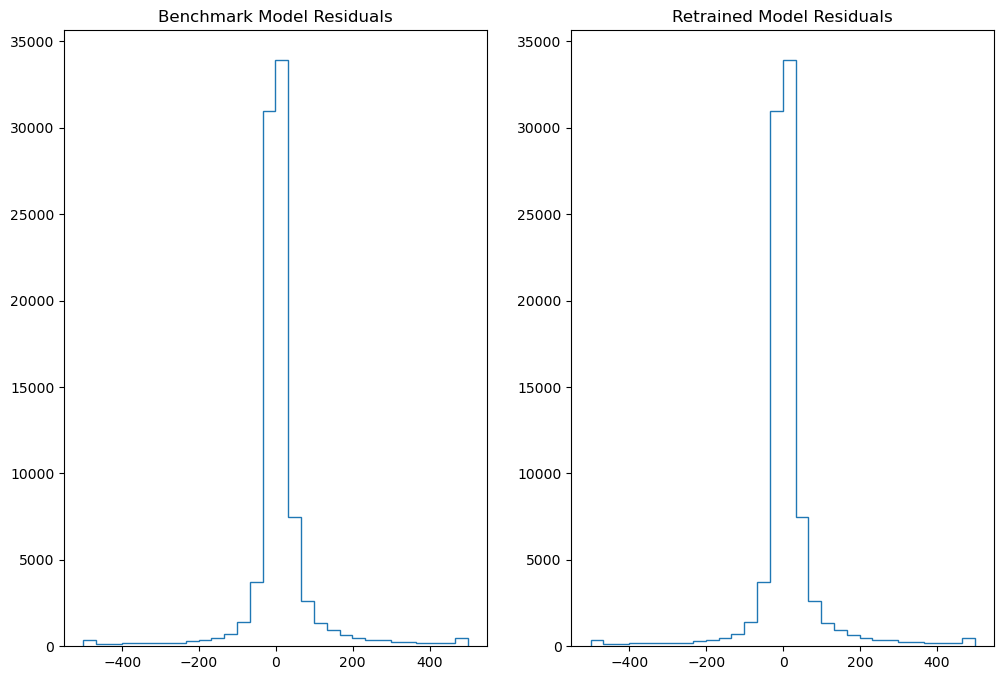

In [59]:
sum_traces, sum_benchmark_loss, sum_benchmark_mean_residual,  sum_retrained_loss, sum_retrained_mean_residual = 0,0,0,0,0
num_thresholds = 20
le_thresholds = list(range(100,100*num_thresholds + 1,100))
benchmark_residuals_list = []
retrained_residuals_list = []
sum_retrained_large_errors_counters = {th:0 for th in le_thresholds}
for batch_idx, dataset_dict in enumerate(loader):

    traces=dataset_dict['X']
    labels = dataset_dict['onset_sample']

    criterion = loss_fn

    valset_original = CustomDataset(dataset=traces.float(), labels=labels.float(), target_transform=lambda l: (l,label_normal_smooth(l)))

    benchmark_dataloader = DataLoader(valset_original, batch_size=1, shuffle=False)

    benchmark_loss, batch_benchmark_residuals_list =  evaluate_loop(dataloader=benchmark_dataloader, model=pretrained_model, loss_fn=criterion)
                                                                                              # large_error_threshold=LARGE_ERROR_THRESHOLD_SAMPLES)
    retrained_loss, batch_retrained_residuals_list =  evaluate_loop(dataloader=benchmark_dataloader, model=retraining_model, loss_fn=criterion)
                                                                                              # large_error_threshold=LARGE_ERROR_THRESHOLD_SAMPLES)

    benchmark_residuals_list.extend(batch_benchmark_residuals_list)
    retrained_residuals_list.extend(batch_retrained_residuals_list)
    benchmark_residual_tensor =   torch.tensor(benchmark_residuals_list)
    benchmark_residuals_rmse = torch.sqrt(torch.mean(torch.square(benchmark_residual_tensor)))
    benchmark_residual_median = torch.median(benchmark_residual_tensor)
    retrained_residual_tensor =  torch.tensor(retrained_residuals_list)
    retrained_residuals_rmse = torch.sqrt(torch.mean(torch.square(retrained_residual_tensor)))
    retrained_residuals_median = torch.median(retrained_residual_tensor)



    print(f'****   Batch No. {batch_idx}   {traces.shape[0]} traces ****')
    print(f'Benchmark root mean squared residual  {benchmark_residuals_rmse}, large error counters {torch.histogram(benchmark_residual_tensor, bins=5)}')
    print(f'Retrained root mean squared residual {retrained_residuals_rmse}, large error counters {torch.histogram(retrained_residual_tensor, bins=5)}')
    sum_traces+=traces.shape[0]

print('EVALUATION FINISHED', sum_traces, 'traces')

benchmark_residual_tensor =   torch.tensor(benchmark_residuals_list)
benchmark_residuals_rmse = torch.sqrt(torch.mean(torch.square(benchmark_residual_tensor)))
benchmark_residual_median = torch.median(benchmark_residual_tensor)
retrained_residual_tensor =  torch.tensor(retrained_residuals_list)
retrained_residuals_rmse = torch.sqrt(torch.mean(torch.square(retrained_residual_tensor)))
retrained_residuals_median = torch.median(retrained_residual_tensor)
print(f'Benchmark root mean squared residual  {benchmark_residuals_rmse}, median {benchmark_residual_median} ')
print(f'Retrained root mean squared residual {retrained_residuals_rmse}, median {retrained_residuals_median} ')

benchmark_hist, benchmark_bins = torch.histogram(benchmark_residual_tensor, bins=30)
retrained_hist, retrained_bins = torch.histogram(retrained_residual_tensor, bins=30)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,8))
ax1.set_title('Benchmark Model Residuals')
ax2.set_title('Retrained Model Residuals')
ax1.stairs(benchmark_hist, benchmark_bins)
ax2.stairs(retrained_hist, retrained_bins)

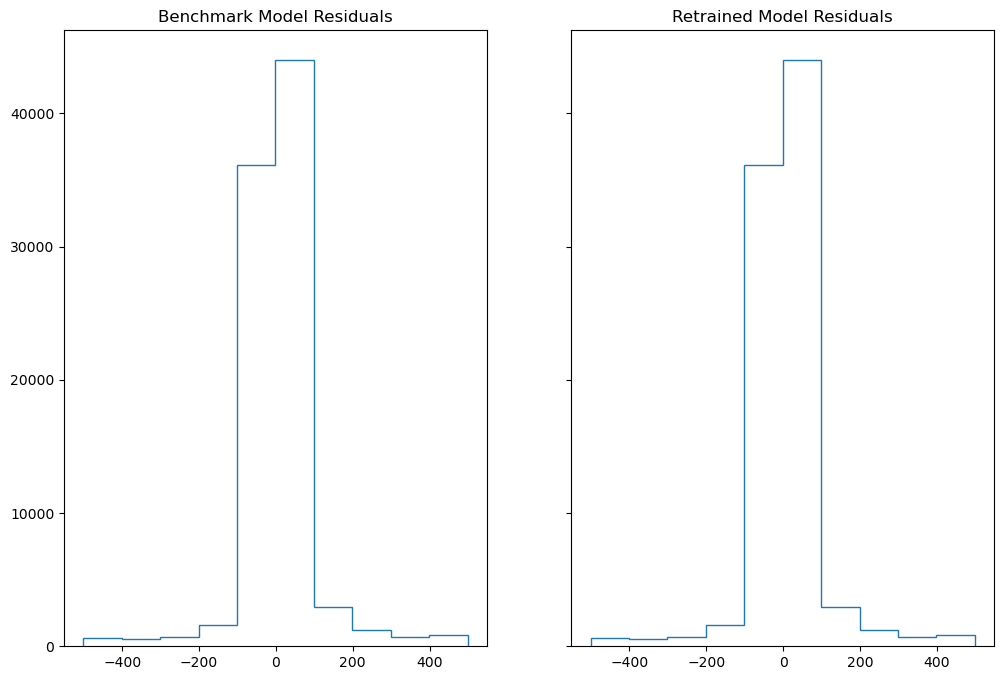

In [60]:
benchmark_hist, benchmark_bins = torch.histogram(benchmark_residual_tensor, bins=10)
retrained_hist, retrained_bins = torch.histogram(retrained_residual_tensor, bins=10)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,8), sharey='all', sharex='all')
ax1.set_title('Benchmark Model Residuals')
ax2.set_title('Retrained Model Residuals')
ax1.stairs(benchmark_hist, benchmark_bins)
ax2.stairs(retrained_hist, retrained_bins)

In [61]:
# print(sum_benchmark_large_errors_counters.values())

In [62]:
# print(sum_retrained_large_errors_counters.values())

In [63]:
# fig, (ax1, ax2) = plt.subplots(1,2, sharey='all', figsize=(12,8))
# ax1.stairs(list(sum_benchmark_large_errors_counters.values()),list(sum_benchmark_large_errors_counters.keys())+[1100]);
# ax1.set_title('Pretrained - Benchmark')
# ax2.stairs(list(sum_retrained_large_errors_counters.values()),list(sum_retrained_large_errors_counters.keys())+[1100]);
# ax2.set_title('Retrained')

In [64]:
# sum_benchmark_loss/sum_traces,  sum_retrained_loss/sum_traces

In [65]:
# sum_benchmark_mean_residual/len(loader), sum_retrained_mean_residual/len(loader)

In [66]:
# len(loader)

In [67]:
# sum_benchmark_large_errors_counter*100/sum_traces,  sum_retrained_large_errors_counter*100/sum_traces

In [68]:
# stead_data = sbd.STEAD(sampling_rate=SAMPLING_RATE, force=True).test()
# print(stead_data)

In [69]:
# le_original_dataset_path = os.path.join(DATASET_PATH, 'le_original_dataset.pt')
# assert_path_exists(path_str=le_original_dataset_path)
# le_original_labels_path = os.path.join(DATASET_PATH, 'le_original_labels.pt')
# assert_path_exists(path_str=le_original_labels_path)

In [70]:
# le_original_dataset, le_original_labels = load_dataset_and_labels(dataset_path=le_original_dataset_path, labels_path=le_original_labels_path)

In [71]:
# print(f'Loaded {le_original_dataset.shape[0]} traces')